In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import glob

# Precinct Shapefile
---
## VEST's Documentation File

Election results from South Carolina State Election Commission (https://www.enr-scvotes.org/SC/106502/Web02-state.264691/#/). Precinct shapefile provided by Victor Frontroth at the Mapping Section of the South Carolina Revenue and Fiscal Affairs Office.

Provisional and failsafe ballots were reported countywide. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

In Jasper County the SC legislature enacted Hardeeville 3 and Okatie 2 for the 2020 elections. However, if in use they were not reported separately so Hardeeville 1/3 and Okatie 1/2 were merged in the shapefile.

* G20PRERTRU - Donald J. Trump (Republican Party)
* G20PREDBID - Joseph R. Biden (Democratic Party)
* G20PRELJOR - Jo Jorgensen (Libertarian Party)
* G20PREGHAW - Howie Hawkins (Green Party)
* G20PREAFUE - Roque Rocky De La Fuente (Alliance Party)


* G20USSRGRA - Lindsey Graham (Republican Party)
* G20USSDHAR - Jaime Harrison (Democratic Party)
* G20USSCBLE - Bill Bledsoe (Constitution Party)
* G20USSOWRI - Write-in Votes


## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/sc_2020/sc_2020.shp")

In [3]:
vest_shp.shape

(2263, 13)

In [4]:
vest_shp.head(10)

,COUNTY,PCODE,CODE_NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,G20PREAFUE,G20USSRGRA,G20USSDHAR,G20USSCBLE,G20USSOWRI,geometry
0,013,110,Burton 1A,766,625,19,2,1,747,647,13,1,"POLYGON ((2081535.382 215004.054, 2081567.367 ..."
1,013,111,Burton 1B,160,650,8,5,4,142,679,7,1,"POLYGON ((2080472.818 230194.779, 2080553.893 ..."
2,013,113,Burton 2A,673,500,14,5,0,649,520,24,1,"POLYGON ((2072206.770 204596.893, 2072315.121 ..."
3,013,114,Burton 2B,702,570,30,7,0,676,603,22,2,"POLYGON ((2080482.426 205724.589, 2080461.848 ..."
4,013,115,Burton 2C,957,555,15,4,2,948,565,21,0,"POLYGON ((2090215.730 217959.230, 2090221.360 ..."
5,013,130,Ladys Island 1A,594,533,18,1,1,586,540,16,1,"POLYGON ((2119623.663 232536.327, 2119646.971 ..."
6,013,131,Ladys Island 1B,644,620,12,4,0,675,604,9,0,"POLYGON ((2110337.587 209993.311, 2110462.223 ..."
7,013,132,Ladys Island 2A,786,381,20,3,1,783,388,18,3,"POLYGON ((2112935.189 235145.363, 2113031.110 ..."
8,013,186,Ladys Island 2C,444,263,8,1,1,449,261,6,0,"POLYGON ((2115354.174 235171.126, 2115382.089 ..."
9,013,134,Ladys Island 3A,482,321,10,0,1,488,319,7,1,"POLYGON ((2106419.494 236488.047, 2106415.006 ..."


<AxesSubplot:>

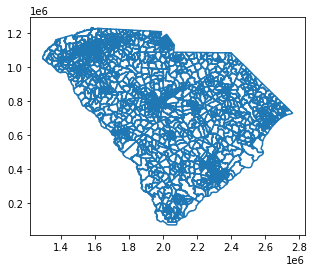

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['COUNTY', 'PCODE', 'CODE_NAME', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREAFUE', 'G20USSRGRA', 'G20USSDHAR',
       'G20USSCBLE', 'G20USSOWRI', 'geometry'],
      dtype='object')

# Election Results

## Load Files
The SOS directed to this link for election results for the 2020 general: (https://www.enr-scvotes.org/SC/106502/Web02-state.264691/#/)

The order of presidential candidates' election results for Allendale County have been changed to match the order of other counties. 

In [7]:
# Change setting to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# Select the folder with all the needed files
folder = os.listdir("./raw-from-source/Election_Results/0_Excel/")
# Create an empty list to add the all data
files = []
# Loop over all the files in the folder
for val in folder:
    # Set a file path
    file_string = "./raw-from-source/Election_Results/0_Excel/" + val
    # Import file + specify sheets
    df = pd.concat(pd.read_excel(file_string, sheet_name = ['3','4']), axis = 1)
    # Flatten out the multi-level index
    df.columns = df.columns.droplevel()
    # Make the row with the candidates' names be the column names
    df.columns = df.iloc[0]
    # Rename the column with the precinct names as 'Precinct'
    df = df.rename(columns = {df.columns[0]:'Precinct'})
    # Add a number to each column
    df.columns = [f'{i}_{x}' for i, x in enumerate(df.columns, 1)]
    # Capitalize column names
    df.columns = df.columns.str.upper()
    # Drop the first two rows (rows without data)
    df = df.iloc[2:]    
    # Drop the rows with totals
    df = df[df['1_PRECINCT'] != 'Total:']
    # Add the county column
    df["COUNTY_NAME"] = val[:len(val) - 5]
    # Add the data to the list
    files.append(df)
#Create the final dataframe
sc_20 = pd.concat(files)

In [9]:
sc_20.columns

Index(['1_PRECINCT', '2_PRECINCT', '3_GRN HOWIE HAWKINS | ANGELA WALKER',
       '4_PRECINCT', '5_PRECINCT', '6_PRECINCT', '7_PRECINCT', '8_PRECINCT',
       '9_PRECINCT', '10_REP DONALD J TRUMP | MICHAEL R PENCE', '11_PRECINCT',
       '12_PRECINCT', '13_PRECINCT', '14_PRECINCT', '15_PRECINCT',
       '16_PRECINCT', '17_ALN ROQUE ROCKY DE LA FUENTE | DARCY G RICHARDSON',
       '18_PRECINCT', '19_PRECINCT', '20_PRECINCT', '21_PRECINCT',
       '22_PRECINCT', '23_PRECINCT',
       '24_LIB JO JORGENSEN | JEREMY SPIKE COHEN', '25_PRECINCT',
       '26_PRECINCT', '27_PRECINCT', '28_PRECINCT', '29_PRECINCT',
       '30_PRECINCT', '31_DEM JOSEPH R BIDEN | KAMALA D HARRIS', '32_PRECINCT',
       '33_PRECINCT', '34_PRECINCT', '35_PRECINCT', '36_PRECINCT',
       '37_PRECINCT', '38_PRECINCT', '39_PRECINCT', '40_PRECINCT',
       '41_CON BILL BLEDSOE', '42_PRECINCT', '43_PRECINCT', '44_PRECINCT',
       '45_PRECINCT', '46_PRECINCT', '47_PRECINCT', '48_REP LINDSEY GRAHAM',
       '49_PRECINCT', 

In [10]:
# Select the columns/data needed for validation
sc_20 = sc_20[['1_PRECINCT', '9_PRECINCT', '16_PRECINCT', '23_PRECINCT', '30_PRECINCT', 
               '37_PRECINCT', '47_PRECINCT', '54_PRECINCT', '61_PRECINCT', 
               '68_PRECINCT', 'COUNTY_NAME']]

In [11]:
# Rename the columns to match that of VEST's
sc_20 = sc_20.rename(columns = {'1_PRECINCT':'PRECINCT', 
                                '9_PRECINCT':'G20PREGHAW',
                                '16_PRECINCT':'G20PRERTRU',
                                '23_PRECINCT':'G20PREAFUE',
                                '30_PRECINCT':'G20PRELJOR',
                                '37_PRECINCT':'G20PREDBID',
                                '47_PRECINCT':'G20USSCBLE',
                                '54_PRECINCT':'G20USSRGRA',
                                '61_PRECINCT':'G20USSDHAR',
                                '68_PRECINCT':'G20USSOWRI'})

# Reorder the columns to match that of VEST's
sc_20 = sc_20[['COUNTY_NAME','PRECINCT', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW',
       'G20PREAFUE', 'G20USSRGRA', 'G20USSDHAR', 'G20USSCBLE', 'G20USSOWRI']]

In [12]:
# Reset index
sc_20 = sc_20.reset_index(drop=True)

In [13]:
# Capitalize the first letter of the county names
sc_20['COUNTY_NAME'] = sc_20['COUNTY_NAME'].str.capitalize()
sc_20 = sc_20.replace('Mccormick','McCormick')

In [14]:
# Change strings to integers (County and Precinct columns remain unchanged)
sc_20 = sc_20.apply(pd.to_numeric, errors='ignore')

In [15]:
sc_20.columns

Index(['COUNTY_NAME', 'PRECINCT', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREAFUE', 'G20USSRGRA', 'G20USSDHAR', 'G20USSCBLE',
       'G20USSOWRI'],
      dtype='object')

## Validation

### Statewide Candidate Totals 

In [16]:
data_columns = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREAFUE', 'G20USSRGRA', 'G20USSDHAR', 'G20USSCBLE',
       'G20USSOWRI']

In [17]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [18]:
statewide_totals_check(vest_shp,sc_20,data_columns)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 1385103
G20PREDBID is equal 	VEST / RDH: 1091541
G20PRELJOR is equal 	VEST / RDH: 27916
G20PREGHAW is equal 	VEST / RDH: 6907
G20PREAFUE is equal 	VEST / RDH: 1862
G20USSRGRA is equal 	VEST / RDH: 1369137
G20USSDHAR is equal 	VEST / RDH: 1110828
G20USSCBLE is equal 	VEST / RDH: 32845
G20USSOWRI is equal 	VEST / RDH: 2294


### County Totals

#### Add in County FIPS Data

In [19]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Carolina"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
SC_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Use the dictionary to go from a county name to a county FIPS and vice versa
sc_20["COUNTY"] = sc_20["COUNTY_NAME"].map(SC_fips_dict).fillna(sc_20["COUNTY_NAME"])

# Check the number of counties - looking for 46
print(len(sc_20["COUNTY"].unique()))

46


#### Check the Results

In [20]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [21]:
county_totals_check(vest_shp,sc_20,data_columns,"COUNTY", full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PREAFUE is equal across all counties
G20USSRGRA is equal across all counties
G20USSDHAR is equal across all counties
G20USSCBLE is equal across all counties
G20USSOWRI is equal across all counties


### Precinct Totals

#### Allocate Absentee Votes 

In [22]:
to_allocate_list = ['Failsafe','Provisional','Failsafe Provisional']

to_allocate = sc_20[sc_20["PRECINCT"].isin(to_allocate_list)]
to_add_to = sc_20[~sc_20["PRECINCT"].isin(to_allocate_list)]

In [23]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [24]:
sc_20 = allocate_absentee(to_add_to,to_allocate,data_columns,'COUNTY')

#### Join Attmpt 1

In [25]:
vest_shp['CODE_NAME'] = vest_shp['CODE_NAME'].str.capitalize()
sc_20['PRECINCT'] = sc_20['PRECINCT'].str.capitalize()

In [26]:
#Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTY"]+"-"+vest_shp["CODE_NAME"]
#Check to make sure it is unique
# print(vest_shp["join_col"].value_counts(dropna=False))

#Create an election results join col
sc_20["join_col"] = sc_20["COUNTY"]+"-"+sc_20["PRECINCT"]
#Check to make sure it is unique
# print(sc_18["join_col"].value_counts(dropna=False))

In [27]:
join_attempt_one = pd.merge(vest_shp,sc_20,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

both          2215
left_only       48
right_only      46
Name: _merge, dtype: int64

In [28]:
election_vest_id_changes_dict ={'009-Hightowers mill': "009-Hightower's mill", '011-Barnwell 1': '011-Barnwell no. 1', '011-Barnwell 2': '011-Barnwell no. 2', '011-Barnwell 3': '011-Barnwell no. 3', '011-Barnwell 4': '011-Barnwell no. 4', '011-Blackville 1': '011-Blackville no. 1', '011-Blackville 2': '011-Blackville no. 2', '011-Williston 1': '011-Williston no. 1', '011-Williston 2': '011-Williston no. 2', '011-Williston 3': '011-Williston no. 3', '025-Angelus-cararrh': '025-Angelus-catarrh', '063-Lake murray 1': '063-Lake murray #1', '063-Old barnwell road': '063-Old barnwell rd', '063-Beulah  church': '063-Beulah church', '063-Red bank south 1': '063-Red bank south #1', '063-Edmund 1': '063-Edmund #1', '063-Pelion 1': '063-Pelion #1', '063-Swansea 1': '063-Swansea #1', '063-Gaston 1': '063-Gaston #1', '063-Cayce no. 1': '063-Cayce ward no.1', '063-Cayce no. 2': '063-Cayce ward no.2', '063-Cayce no. 3': '063-Cayce ward no.3', '063-Congaree 1': '063-Congaree #1', '063-West columbia no. 1': '063-W columbia no 1', '063-West columbia no. 2': '063-W columbia no 2', '063-West columbia no. 3': '063-W columbia no 3', '063-West columbia no. 4': '063-W columbia no 4', '063-Cayce 2a': '063-Cayce ward 2-a', '063-Barr road 1': '063-Barr road #1', '063-Pilgrim chruch': '063-Pilgrim church', '063-Park road 1': '063-Park road #1', '063-Gaston 2': '063-Gaston #2', '063-Lake murray 2': '063-Lake murray #2', '063-Congaree 2': '063-Congaree #2', '063-St. davids': '063-St davids', '063-Mt. hebron': '063-Mt hebron', '063-Sand hill': '063-Sandhill', '063-Edmund 2': '063-Edmund #2', '063-Swansea 2': '063-Swansea #2', '063-Pelion 2': '063-Pelion #2', '063-Park road 2': '063-Park road #2', '063-Barr road 2': '063-Barr road #2', '063-Red bank south 2': '063-Red bank south #2', '053-Oakatie': '053-Okatie', '063-Pine ridge 1': '063-Pineridge #1', '063-Pine ridge 2': '063-Pineridge #2'}
sc_20["join_col"] = sc_20["join_col"].map(election_vest_id_changes_dict).fillna(sc_20["join_col"])

#### Join Attmpt 2

In [29]:
join_attempt_two = pd.merge(vest_shp,sc_20,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

both          2261
left_only        2
right_only       0
Name: final_merge, dtype: int64


In [30]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [31]:
precinct_votes_check(join_attempt_two[join_attempt_two["final_merge"]=="both"], data_columns,False,"join_col")

G20PRERTRU .........................................................003-Aiken no. 1 (S) ..616  (V)..617 (D):   -1
G20PREDBID .........................................................003-Aiken no. 1 (S) ..370  (V)..371 (D):   -1
G20USSRGRA .........................................................003-Aiken no. 1 (S) ..629  (V)..630 (D):   -1
G20PREDBID .........................................................003-Aiken no. 3 (S) ..845  (V)..843 (D):    2
G20USSDHAR .........................................................003-Aiken no. 3 (S) ..864  (V)..862 (D):    2
G20PREDBID .........................................................003-Aiken no. 4 (S) ..366  (V)..367 (D):   -1
G20USSDHAR .........................................................003-Aiken no. 4 (S) ..372  (V)..373 (D):   -1
G20USSRGRA ........................................................003-Aiken no. 47 (S) ..469  (V)..470 (D):   -1
G20PRERTRU .........................................................003-Aiken no. 6 (S) 

G20USSRGRA ..........................................................007-Gluck mill (S) ..502  (V)..501 (D):    1
G20PREDBID ................................................007-Green pond station a (S) ..411  (V)..410 (D):    1
G20USSRGRA ................................................007-Green pond station a (S) .1398  (V).1399 (D):   -1
G20USSDHAR ................................................007-Green pond station a (S) ..437  (V)..436 (D):    1
G20PREDBID .......................................................007-Hammond annex (S) ..432  (V)..431 (D):    1
G20USSDHAR .......................................................007-Hammond annex (S) ..417  (V)..416 (D):    1
G20PRERTRU ......................................................007-Hammond school (S) .1383  (V).1384 (D):   -1
G20PRELJOR ......................................................007-Hammond school (S) ...29  (V)...30 (D):   -1
G20USSRGRA ......................................................007-Hammond school (S) 

G20USSRGRA ......................................................011-Barnwell no. 2 (S) ..667  (V)..666 (D):    1
G20PREDBID ......................................................011-Barnwell no. 3 (S) ..496  (V)..495 (D):    1
G20USSRGRA ......................................................011-Barnwell no. 3 (S) ..727  (V)..726 (D):    1
G20PRERTRU ................................................................011-Elko (S) ..248  (V)..249 (D):   -1
G20PREDBID ................................................................011-Elko (S) ..188  (V)..189 (D):   -1
G20USSRGRA ................................................................011-Elko (S) ..243  (V)..244 (D):   -1
G20PRERTRU ...............................................................011-Hilda (S) ..578  (V)..577 (D):    1
G20USSRGRA ...............................................................011-Hilda (S) ..562  (V)..561 (D):    1
G20PRERTRU ...............................................................011-Kline (S) 

G20USSRGRA ...............................................................015-Alvin (S) ..276  (V)..277 (D):   -1
G20PRERTRU .......................................................015-Beverly hills (S) ..422  (V)..423 (D):   -1
G20USSRGRA .......................................................015-Beverly hills (S) ..409  (V)..410 (D):   -1
G20PRERTRU .............................................................015-Bonneau (S) ..611  (V)..610 (D):    1
G20PREDBID .............................................................015-Bonneau (S) ..326  (V)..327 (D):   -1
G20USSDHAR .............................................................015-Bonneau (S) ..340  (V)..341 (D):   -1
G20PRERTRU .......................................................015-Bonneau beach (S) ..915  (V)..914 (D):    1
G20PREDBID .......................................................015-Bonneau beach (S) ..246  (V)..247 (D):   -1
G20USSRGRA .......................................................015-Bonneau beach (S) 

G20USSDHAR .......................................................015-Wassamassaw 2 (S) ..745  (V)..744 (D):    1
G20PREDBID ........................................................015-Weatherstone (S) ..648  (V)..649 (D):   -1
G20USSDHAR ........................................................015-Weatherstone (S) ..664  (V)..665 (D):   -1
G20PRERTRU ..........................................................015-Westview 2 (S) ..796  (V)..795 (D):    1
G20USSRGRA ..........................................................015-Westview 2 (S) ..787  (V)..786 (D):    1
G20PREDBID .......................................................015-Whitesville 1 (S) ..792  (V)..791 (D):    1
G20USSRGRA .......................................................015-Whitesville 1 (S) ..642  (V)..641 (D):    1
G20USSDHAR .......................................................015-Whitesville 1 (S) ..803  (V)..802 (D):    1
G20PRERTRU .......................................................015-Whitesville 2 (S) 

G20PRERTRU ......................................021-Ninety nine and cherokee falls (S) ..628  (V)..629 (D):   -1
G20USSRGRA ........................................................021-Timber ridge (S) ..667  (V)..668 (D):   -1
G20PREDBID ...............................................................021-Woods (S) ..117  (V)..118 (D):   -1
G20PRERTRU .....................................................025-Angelus-catarrh (S) ..333  (V)..334 (D):   -1
G20USSRGRA .....................................................025-Angelus-catarrh (S) ..327  (V)..328 (D):   -1
G20PRERTRU ..................................................025-Center grove-winzo (S) ..339  (V)..340 (D):   -1
G20USSRGRA ........................................................025-Cheraw no. 2 (S) ..338  (V)..339 (D):   -1
G20PRERTRU ..........................................................025-Courthouse (S) ..947  (V)..946 (D):    1
G20USSRGRA ..........................................................025-Courthouse (S) 

G20PREDBID .........................................................045-Clear creek (S) ..297  (V)..298 (D):   -1
G20PRERTRU ............................................................045-Conestee (S) ..858  (V)..857 (D):    1
G20PREDBID .........................................................045-Darby ridge (S) ..467  (V)..468 (D):   -1
G20USSRGRA .........................................................045-Darby ridge (S) .1666  (V).1665 (D):    1
G20PREDBID ...........................................................045-Donaldson (S) ..643  (V)..642 (D):    1
G20PRERTRU .............................................................045-Dunklin (S) .1526  (V).1527 (D):   -1
G20USSDHAR .............................................................045-Dunklin (S) ..276  (V)..277 (D):   -1
G20USSCBLE .............................................................045-Dunklin (S) ...45  (V)...44 (D):    1
G20PRELJOR ............................................................045-Eastside (S) 

G20PREDBID ............................................................051-Dunes #2 (S) ..519  (V)..518 (D):    1
G20USSDHAR ............................................................051-Dunes #2 (S) ..514  (V)..513 (D):    1
G20PRERTRU .........................................................051-East conway (S) ..703  (V)..702 (D):    1
G20USSRGRA .........................................................051-East conway (S) ..694  (V)..693 (D):    1
G20USSDHAR ............................................................051-Ebenezer (S) ..512  (V)..511 (D):    1
G20PRERTRU ...................................................051-Emerald forest #3 (S) .1517  (V).1518 (D):   -1
G20PREDBID ...................................................051-Emerald forest #3 (S) ..833  (V)..832 (D):    1
G20USSDHAR ...................................................051-Emerald forest #3 (S) ..864  (V)..863 (D):    1
G20USSRGRA ..........................................................051-Enterprise (S) 

G20USSRGRA ..............................................................051-Wampee (S) ..626  (V)..627 (D):   -1
G20PREDBID .........................................................051-West conway (S) ..267  (V)..268 (D):   -1
G20USSDHAR .........................................................051-West conway (S) ..274  (V)..275 (D):   -1
G20USSRGRA ..........................................................051-West loris (S) ..213  (V)..214 (D):   -1
G20PRERTRU ...........................................................051-Wild wing (S) .1843  (V).1844 (D):   -1
G20USSCBLE ...........................................................051-Wild wing (S) ...51  (V)...50 (D):    1
G20PRERTRU .......................................................051-Windy hill #1 (S) ..791  (V)..790 (D):    1
G20USSRGRA .......................................................051-Windy hill #1 (S) ..788  (V)..787 (D):    1
G20PREDBID .......................................................053-Hardeeville 1 (S) 

G20PRERTRU ........................................................063-Quail valley (S) ..842  (V)..841 (D):    1
G20PREDBID ........................................................063-Quail valley (S) ..771  (V)..770 (D):    1
G20USSDHAR ........................................................063-Quail valley (S) ..753  (V)..752 (D):    1
G20PREDBID ............................................................063-Red bank (S) ..900  (V)..899 (D):    1
G20USSDHAR ............................................................063-Red bank (S) ..942  (V)..940 (D):    2
G20USSCBLE ............................................................063-Red bank (S) ...59  (V)...57 (D):    2
G20USSRGRA ...................................................063-Red bank south #1 (S) .1038  (V).1037 (D):    1
G20PRERTRU ...................................................063-Red bank south #2 (S) ..881  (V)..880 (D):    1
G20PREDBID ..........................................................063-Ridge road (S) 

G20USSRGRA .............................................................077-Skelton (S) ..787  (V)..786 (D):    1
G20USSDHAR .........................................................077-Smith grove (S) ..160  (V)..161 (D):   -1
G20PREDBID .......................................................077-South central (S) ..357  (V)..355 (D):    2
G20USSDHAR .......................................................077-South central (S) ..382  (V)..380 (D):    2
G20PRERTRU .......................................................077-South pickens (S) ..619  (V)..620 (D):   -1
G20PREDBID .......................................................077-South pickens (S) ..228  (V)..229 (D):   -1
G20USSDHAR .......................................................077-South pickens (S) ..246  (V)..247 (D):   -1
G20PRERTRU ........................................................077-Stone church (S) ..385  (V)..384 (D):    1
G20PREDBID ........................................................077-Stone church (S) 

G20USSDHAR ...........................................................079-Wildewood (S) .1285  (V).1284 (D):    1
G20PRERTRU ...........................................................079-Woodfield (S) ..415  (V)..416 (D):   -1
G20PREDBID ...........................................................079-Woodfield (S) .1354  (V).1353 (D):    1
G20USSRGRA ...........................................................079-Woodfield (S) ..384  (V)..385 (D):   -1
G20USSDHAR ...........................................................079-Woodfield (S) .1384  (V).1383 (D):    1
G20PRERTRU ...........................................................079-Woodlands (S) .1011  (V).1010 (D):    1
G20USSRGRA ...........................................................079-Woodlands (S) .1084  (V).1083 (D):    1
G20PRERTRU .................................................083-Abner creek baptist (S) .1209  (V).1208 (D):    1
G20PREDBID .................................................083-Abner creek baptist (S) 

G20USSCBLE ...............................................................091-Larne (S) ...35  (V)...36 (D):   -1
G20PRERTRU ..........................................................091-Mcconnells (S) ..863  (V)..862 (D):    1
G20PRERTRU ..........................................................091-Mill creek (S) ..668  (V)..669 (D):   -1
G20PREDBID ..........................................................091-Mill creek (S) ..264  (V)..263 (D):    1
G20USSRGRA ..........................................................091-Mill creek (S) ..657  (V)..658 (D):   -1
G20PREDBID .........................................................091-Mt. gallant (S) ..499  (V)..500 (D):   -1
G20USSDHAR .........................................................091-Mt. gallant (S) ..510  (V)..511 (D):   -1
G20USSDHAR ...........................................................091-Mt. holly (S) .1135  (V).1134 (D):    1
G20PRERTRU .........................................................091-Nation ford (S) 